In [1]:
import processing
import ds
import ml
import model_saving
import TS

Using TensorFlow backend.


In [2]:
filename = '/home/octo/Dropbox'+ '/SPY21Dec.csv'

In [3]:
data=processing.get_csv_pd(filename)
data=processing.BA(data)
data=processing.preprocessing(data)
data_km=ml.kalman_ma(data)
data['km']=data_km

In [4]:
import numpy as np
data['diff']=np.where(np.logical_and(data.Open>data.km,data.spread>0),data.vwap-data.km,np.where(np.logical_and(data.Open<data.km,data.spread<0),data.vwap-data.km,0))

https://www.quantinsti.com/blog/machine-learning-k-nearest-neighbors-knn-algorithm-python/

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [25]:
data.tail()

,askPrice,askSize,bidPrice,bidSize,Open,Close,High,Low,...,spread,vel,return,km,diff,Op-Cl,H-L,CLD
2017-12-22 08:43:41.354203,268.01001,67.00000,268.00000,38.00000,268.00500,268.00500,268.01001,268.00000,...,-0.00137,0.02002,0.00004,268.00133,0.00000,0.00000,0.01001,0.00000
2017-12-22 08:43:43.959309,268.01001,67.00000,268.00000,33.00000,268.00500,268.00500,268.01001,268.00000,...,-0.00171,0.02002,0.00004,268.00168,0.00000,0.00000,0.01001,0.00000
2017-12-22 08:43:46.158100,268.01001,74.00000,268.00000,33.00000,268.00500,268.00500,268.01001,268.00000,...,-0.00192,0.02002,0.00004,268.00199,0.00000,0.00000,0.01001,0.00000
2017-12-22 08:43:48.568004,268.01001,74.00000,268.00000,32.00000,268.00500,268.00500,268.01001,268.00000,...,-0.00198,0.02002,0.00004,268.00228,0.00000,0.00000,0.01001,0.00000
2017-12-22 08:43:51.341810,268.01001,201.00000,268.00000,32.00000,268.00500,268.00500,268.01001,268.00000,...,-0.00363,0.02002,0.00004,268.00254,0.00000,0.00000,0.01001,0.00000


In [26]:
# defining predictor variable
data['BASD']=data.bidSize-data.askSize
data['H-L']=data.High-data.Low
data=data.dropna()
X=data[['BASD','H-L','diff','vel']]
X.head()

,BASD,H-L,diff,vel
2017-12-21 20:00:11.350348,153.00000,0.02002,0.44007,-0.03500
2017-12-21 20:00:11.572921,153.00000,0.02002,0.40383,-0.03000
2017-12-21 20:00:11.583070,-70.00000,0.02002,0.00000,-0.01999
2017-12-21 20:00:11.592699,-70.00000,0.02002,0.00000,-0.01999
2017-12-21 20:00:11.602544,-191.00000,0.02002,0.00000,-0.01999


In [27]:
# Defining target variable
Y=np.where(data.Close.diff(5)>0,1,-1)

In [28]:
Y[:5]

array([-1, -1, -1, -1, -1])

In [29]:
# training set and test set
split_percentage=0.7
split=int(split_percentage*len(data))
X_train=X[:split]
Y_train=Y[:split]
X_test=X[split:]
Y_test=Y[split:]

In [30]:
knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train,Y_train)
accuracy_train=accuracy_score(Y_train,knn.predict(X_train))
accuracy_test=accuracy_score(Y_test,knn.predict(X_test))
print('training set sccuracy: %2.f' %accuracy_train)
print('test set sccuracy: %2.f' %accuracy_test)

training set sccuracy:  1
test set sccuracy:  1


In [32]:
# Creating trading strategy
data['pr_signal']=knn.predict(X)
data['ret']=np.log(data.Close/data.Close.shift(5))
cum_ret=data[split:].ret.cumsum()*100
data['strat_ret']=data.ret*data.pr_signal.shift(1)
cum_strat_ret=data[split:].strat_ret.cumsum()*100

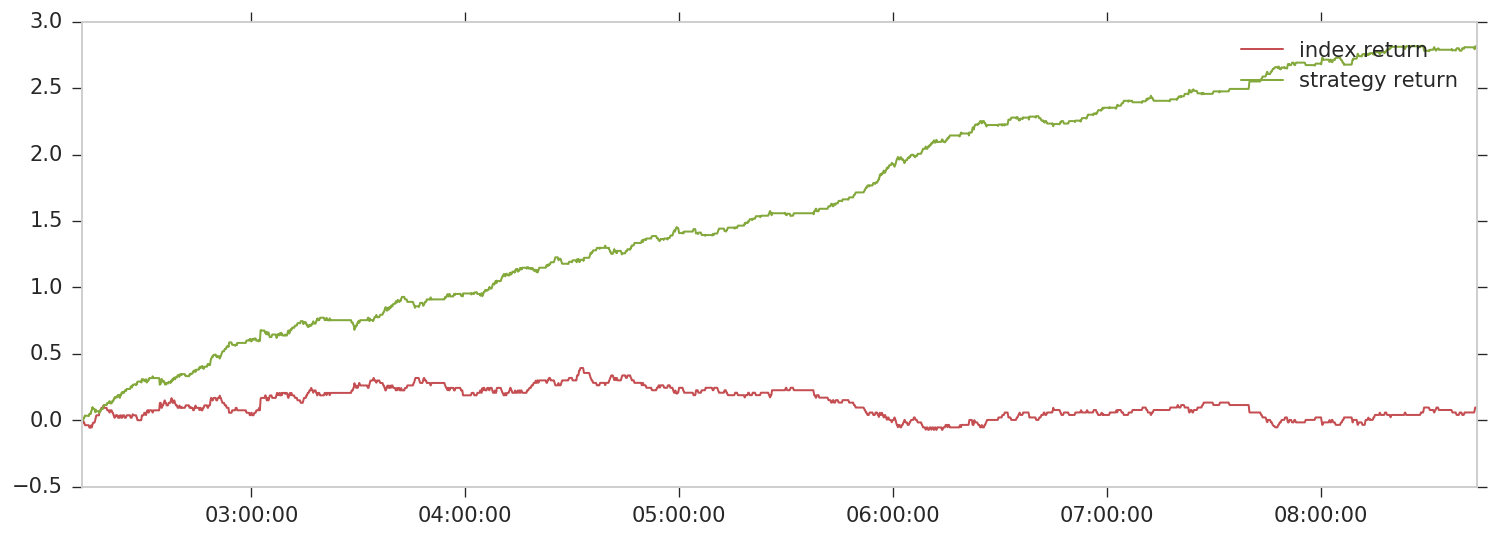

In [33]:
#plot
plt.figure(figsize=(15,5))
plt.plot(cum_ret,color='r',label='index return')
plt.plot(cum_strat_ret,color='g',label='strategy return')
plt.legend()
plt.show()

In [36]:
# sharp ratio
std=cum_strat_ret.std()
Sharpe=(cum_strat_ret-cum_ret)/std
Sharpe=Sharpe.mean()
print('Sharpe ratio: %.2f' %Sharpe)

Sharpe ratio: 1.70
